In [1]:
# %load_ext autoreload
# %autoreload 2

# Experiment Pipeline

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as TV

from pathlib import Path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from hubmap.dataset import TrainDataset, ValDataset
from hubmap.data import DATA_DIR
from checkpoints import CHECKPOINT_DIR

from hubmap.dataset import transforms as T
from hubmap.losses import BCEDiceLoss
from hubmap.losses import MultiOutputBCELoss
from hubmap.losses import ClassWeightedBCELoss
from hubmap.metrics import IoU
from hubmap.training import train
from hubmap.training import LRScheduler
from hubmap.training import EarlyStopping

from hubmap.metrics import model_size

import matplotlib.pyplot as plt

from hubmap.visualization.visualize_mask import mask_to_rgb, mask_to_rgba
from hubmap.dataset import label2id, label2title
import matplotlib.patches as mpatches

First we load the data that we need for the experiment. This includes the training data, the validation (test) data that we will use for training.

For this, depending on the experiments we use different transformations on the data. The following transformations are a minimal example. Furhter transformations should be included for more sophisticated experiments.

In [3]:
IMG_DIM = 256
NUM_EPOCHS = 100
BATCH_SIZE = 16

In [4]:
train_transformations = T.Compose(
    [
        T.ToTensor(),
        T.Resize((IMG_DIM, IMG_DIM)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomCrop((IMG_DIM, IMG_DIM)),
    ]
)

val_transformations = T.Compose(
    [
        T.ToTensor(),
        T.Resize((IMG_DIM, IMG_DIM)),
    ]
)

Depending on the experiment we may want to load all annotated images or just the ones that are annotated by experts.

Here we create a function to load all the images that are annotated (not only the ones by experts).
The created function can than be used to load the data loaders with a specific batch size.

In [5]:
train_dataset = TrainDataset(
    DATA_DIR, transform=train_transformations, with_background=True
)
val_dataset = ValDataset(DATA_DIR, transform=val_transformations, with_background=True)

In [6]:
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16
)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
from hubmap.models.trans_res_u_net.model import TResUnet

model = TResUnet(num_classes=4)
model = model.to(device)

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs = torch.softmax(inputs, dim=1)
        inputs = torch.sigmoid(inputs)

        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (inputs * targets).sum()
        dice = (2.0 * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice


class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs = torch.softmax(inputs, dim=1)
        inputs = torch.sigmoid(inputs)

        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.0 * intersection + smooth) / (
            inputs.sum() + targets.sum() + smooth
        )
        BCE = F.binary_cross_entropy(inputs, targets, reduction="mean")
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# benchmark = IoU()
# criterion0 = nn.CrossEntropyLoss(weight=weights.to(device))
criterion = DiceBCELoss()
learning_rate_scheduler = LRScheduler(optimizer, patience=20)
# learning_rate_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
early_stopping = None

iou = IoU(name="IoU")
iou_blood_vessel = IoU(class_index=label2id["blood_vessel"], name="IoUBV")
iou_glomerulus = IoU(class_index=label2id["glomerulus"], name="IoUGL")
iou_unsure = IoU(class_index=label2id["unsure"], name="IoUUN")
iou_background = IoU(class_index=label2id["background"], name="IoUBG")
# metrics = [iou, iou_blood_vessel, iou_glomerulus, iou_unsure, iou_background]
metrics = []

In [11]:
checkpoint_name = "tResUNet_run_3_img_512_b_8.pt"

In [26]:
continue_training = True

In [27]:
NUM_EPOCHS = 50

In [28]:
start_epoch = 1

training_loss_history = []
training_metric_history = []

validation_loss_history = []
validation_metric_history = []

if continue_training:
    # Load checkpoint.
    print("Loading checkpoint...")
    checkpoint = torch.load(Path(CHECKPOINT_DIR / checkpoint_name))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    training_loss_history = checkpoint["training_loss_history"]
    training_metric_history = checkpoint["training_metric_history"]
    validation_loss_history = checkpoint["validation_loss_history"]
    validation_metric_history = checkpoint["validation_metric_history"]

for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    # tqdm.write(f"Epoch {epoch}/{num_epochs} - Started training...")
    training_losses = []
    training_accuracies = []
    training_metrics = [[] for i in range(len(metrics))]
    traing_metrics_names = [m.name for m in metrics]

    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)
        # targets = targets[:, 0:1, :, :]

        optimizer.zero_grad()
        predictions = model(images)

        # print(targets.size(), predictions.size())

        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        # probs = F.softmax(predictions, dim=1)
        probs = predictions
        classes = torch.argmax(probs, dim=1, keepdims=True)
        classes_per_channel = torch.zeros_like(predictions)
        classes_per_channel.scatter_(1, classes, 1)

        targets_classes = torch.argmax(targets, dim=1, keepdims=True)
        mask = targets_classes == 0
        correct = (classes[mask] == targets_classes[mask]).sum()
        total = mask.sum()
        accuracy = correct / total

        for i, m in enumerate(metrics):
            training_metrics[i].append(m(predictions, targets).item())

        training_losses.append(loss.item())
        training_accuracies.append(accuracy.item())

    training_loss_history.append(training_losses)
    training_metric_history.append(training_accuracies)

    validation_losses = []
    validation_accuracies = []

    validation_metrics = [[] for i in range(len(metrics))]
    validation_metrics_names = [m.name for m in metrics]

    model.eval()
    for images, targets in val_loader:
        images = images.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            predictions = model(images)
            loss = criterion(predictions, targets)

            # probs = F.softmax(predictions, dim=1)
            probs = predictions
            classes = torch.argmax(probs, dim=1, keepdims=True)
            classes_per_channel = torch.zeros_like(predictions)
            classes_per_channel.scatter_(1, classes, 1)

            targets_classes = torch.argmax(targets, dim=1, keepdims=True)
            mask = targets_classes == 0
            correct = (classes[mask] == targets_classes[mask]).sum()
            total = mask.sum()
            acc = correct / total

            for i, m in enumerate(metrics):
                validation_metrics[i].append(m(predictions, targets).item())

        validation_losses.append(loss.item())
        validation_accuracies.append(acc.item())

    validation_loss_history.append(validation_losses)
    validation_metric_history.append(validation_accuracies)

    log = f"Epoch {epoch}/{NUM_EPOCHS} - Summary: "
    log += f"Train Loss: {np.mean(training_losses):.4f} - "
    log += f"Acc: {np.mean(training_accuracies):.4f} --- "
    # for name, value in zip(traing_metrics_names, training_metrics):
    # log += f"{name}: {np.mean(value):.4f} - "
    log += f"Val Loss: {np.mean(validation_losses):.4f} - "
    log += f"Acc: {np.mean(validation_accuracies):.4f}"
    # for name, value in zip(validation_metrics_names, validation_metrics):
    # log += f"{name}: {np.mean(value):.4f} - "

    print(log)

    data_to_save = {
        "early_stopping": False,
        "epoch": epoch,
        # "start_epoch": start_epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "training_loss_history": training_loss_history,
        "training_metric_history": training_metric_history,
        "validation_loss_history": validation_loss_history,
        "validation_metric_history": validation_metric_history,
    }

    # NOW DO THE ADJUSTMENTS USING THE LEARNING RATE SCHEDULER.
    if learning_rate_scheduler:
        learning_rate_scheduler(np.mean(validation_losses))
    # NOW DO THE ADJUSTMENTS USING THE EARLY STOPPING.
    if early_stopping:
        early_stopping(np.mean(validation_losses))
        # MODIFY THE DATA TO SAVE ACCORDING TO THE EARLY STOPPING RESULT.
        data_to_save["early_stopping"] = early_stopping.early_stop

    # SAVE THE DATA.
    torch.save(data_to_save, Path(CHECKPOINT_DIR / checkpoint_name))

    # DO THE EARLY STOPPING IF NECESSARY.
    if early_stopping and early_stopping.early_stop:
        break

result = {
    "epoch": epoch,
    "training": {
        "loss": training_loss_history,
        "metric": training_metric_history,
    },
    "validation": {
        "loss": validation_loss_history,
        "metric": validation_metric_history,
    },
}

Loading checkpoint...
Epoch 51/50 - Summary: Train Loss: 0.0587 - Acc: 0.7073 --- Val Loss: 0.0889 - Acc: 0.5979
Epoch 52/50 - Summary: Train Loss: 0.0558 - Acc: 0.7178 --- Val Loss: 0.0949 - Acc: 0.6208
Epoch 53/50 - Summary: Train Loss: 0.0642 - Acc: 0.6849 --- Val Loss: 0.1888 - Acc: 0.2443
Epoch 54/50 - Summary: Train Loss: 0.0687 - Acc: 0.6696 --- Val Loss: 0.1027 - Acc: 0.4614
Epoch 55/50 - Summary: Train Loss: 0.0582 - Acc: 0.7066 --- Val Loss: 0.1001 - Acc: 0.5841
Epoch 56/50 - Summary: Train Loss: 0.0556 - Acc: 0.7149 --- Val Loss: 0.0975 - Acc: 0.5092
Epoch 57/50 - Summary: Train Loss: 0.0531 - Acc: 0.7286 --- Val Loss: 0.0957 - Acc: 0.5238
Epoch 58/50 - Summary: Train Loss: 0.0524 - Acc: 0.7342 --- Val Loss: 0.0936 - Acc: 0.5845
Epoch 59/50 - Summary: Train Loss: 0.0508 - Acc: 0.7440 --- Val Loss: 0.0984 - Acc: 0.5106
Epoch 60/50 - Summary: Train Loss: 0.0514 - Acc: 0.7439 --- Val Loss: 0.0980 - Acc: 0.5545
Epoch 61/50 - Summary: Train Loss: 0.0501 - Acc: 0.7464 --- Val Loss

Now we can visualize the results.<br>
(*this needs improvements + better and more visualizations for the final paper*)

In [29]:
from hubmap.visualization import visualize_result

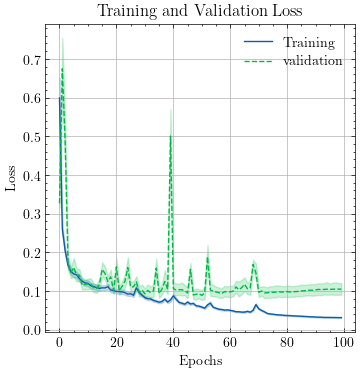

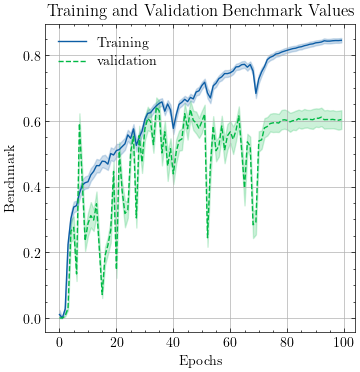

In [30]:
loss_fig, benchmark_fig = visualize_result(result)

In [31]:
data = iter(train_dataset)

In [32]:
image, target = next(data)

In [33]:
plt.style.use(["science"])
image = image.to(device)
model.eval()
with torch.no_grad():
    prediction = model(image.unsqueeze(0))

probs = F.softmax(prediction, dim=1)
classes = torch.argmax(probs, dim=1, keepdims=True)
classes_per_channel = torch.zeros_like(prediction)
classes_per_channel.scatter_(1, classes, 1)
classes_per_channel = classes_per_channel.squeeze(0)
classes = classes.squeeze(0).cpu()

In [34]:
def accuracy(target, prediction, cls_idx):
    target_classes = torch.argmax(target, dim=0, keepdim=True)
    mask = target_classes == cls_idx
    correct = (prediction[mask] == target_classes[mask]).sum().item()
    total = mask.sum().item()
    if total == 0:
        return 1.0
    return correct / total

In [35]:
accuracy(target, classes, 0)

0.5302013422818792

In [36]:
iou = IoU()
iou_score = iou(classes_per_channel, target).item()
iou_blood_vessel = IoU(class_index=label2id["blood_vessel"])
iou_blood_vessel_score = iou_blood_vessel(classes_per_channel, target).item()
iou_glomerulus = IoU(class_index=label2id["glomerulus"])
iou_glomerulus_score = iou_glomerulus(classes_per_channel, target).item()
iou_unsure = IoU(class_index=label2id["unsure"])
iou_unsure_score = iou_unsure(classes_per_channel, target).item()
iou_background = IoU(class_index=label2id["background"])
iou_background_score = iou_background(classes_per_channel, target).item()

In [37]:
acc_bv = accuracy(target, classes, 0)
acc_gl = accuracy(target, classes, 1)
acc_un = accuracy(target, classes, 2)
acc_bg = accuracy(target, classes, 3)

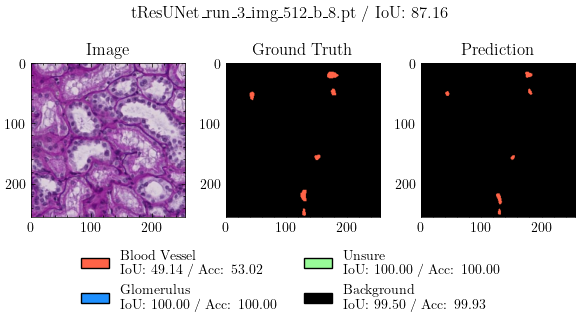

In [38]:
image = image.cpu()
classes_per_channel = classes_per_channel.cpu()

colors = {
    "blood_vessel": "tomato",
    "glomerulus": "dodgerblue",
    "unsure": "palegreen",
    "background": "black",
}
colors = colors
cmap = {label2id[l]: colors[l] for l in colors.keys()}

image_np = image.permute(1, 2, 0).squeeze().numpy()

target_mask_rgb = mask_to_rgb(target, color_map=cmap, bg_channel=-1)
pred_mask_rgb = mask_to_rgb(classes_per_channel, color_map=cmap, bg_channel=-1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 2.5))
axs[0].imshow(image_np)
axs[0].set_title(f"Image")
axs[1].imshow(target_mask_rgb.permute(1, 2, 0))
axs[1].set_title(f"Ground Truth")
axs[2].imshow(pred_mask_rgb.permute(1, 2, 0))
axs[2].set_title(f"Prediction")

blood_vessel_patch = mpatches.Patch(
    facecolor=colors["blood_vessel"],
    label=f"{label2title['blood_vessel']}\nIoU: {iou_blood_vessel_score * 100:.2f} / Acc: {acc_bv * 100:.2f}",
    edgecolor="black",
)
glomerulus_patch = mpatches.Patch(
    facecolor=colors["glomerulus"],
    label=f"{label2title['glomerulus']}\nIoU: {iou_glomerulus_score * 100:.2f} / Acc: {acc_gl * 100:.2f}",
    edgecolor="black",
)
unsure_patch = mpatches.Patch(
    facecolor=colors["unsure"],
    label=f"{label2title['unsure']}\nIoU: {iou_unsure_score * 100:.2f} / Acc: {acc_un * 100:.2f}",
    edgecolor="black",
)
background_patch = mpatches.Patch(
    facecolor=colors["background"],
    label=f"{label2title['background']}\nIoU: {iou_background_score * 100:.2f} / Acc: {acc_bg * 100:.2f}",
    edgecolor="black",
)
handles = [blood_vessel_patch, glomerulus_patch, unsure_patch, background_patch]
fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=2)

fig.suptitle(f"{checkpoint_name} / IoU: {(iou_score * 100):.2f}")
fig.tight_layout()

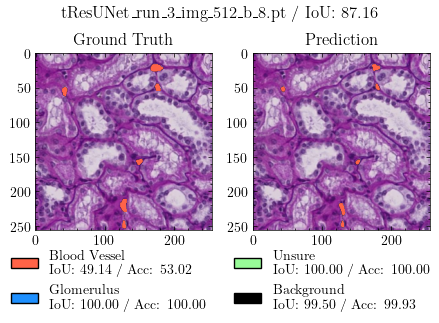

: 

In [39]:
image = image.cpu()
classes_per_channel = classes_per_channel.cpu()

colors = {
    "blood_vessel": "tomato",
    "glomerulus": "dodgerblue",
    "unsure": "palegreen",
    "background": "black",
}
colors = colors
cmap = {label2id[l]: colors[l] for l in colors.keys()}

image_np = image.permute(1, 2, 0).squeeze().numpy()

target_mask_rgba = mask_to_rgba(target, color_map=cmap, bg_channel=3, alpha=1.0)
pred_mask_rgba = mask_to_rgba(
    classes_per_channel, color_map=cmap, bg_channel=3, alpha=1.0
)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4.5, 2.5))
# axs[0].imshow(image_np)
# axs[0].set_title(f"Image")
axs[0].imshow(image_np)
axs[0].imshow(target_mask_rgba.permute(1, 2, 0))
axs[0].set_title(f"Ground Truth")
axs[1].imshow(image_np)
axs[1].imshow(pred_mask_rgba.permute(1, 2, 0))
axs[1].set_title(f"Prediction")

blood_vessel_patch = mpatches.Patch(
    facecolor=colors["blood_vessel"],
    label=f"{label2title['blood_vessel']}\nIoU: {iou_blood_vessel_score * 100:.2f} / Acc: {acc_bv * 100:.2f}",
    edgecolor="black",
)
glomerulus_patch = mpatches.Patch(
    facecolor=colors["glomerulus"],
    label=f"{label2title['glomerulus']}\nIoU: {iou_glomerulus_score * 100:.2f} / Acc: {acc_gl * 100:.2f}",
    edgecolor="black",
)
unsure_patch = mpatches.Patch(
    facecolor=colors["unsure"],
    label=f"{label2title['unsure']}\nIoU: {iou_unsure_score * 100:.2f} / Acc: {acc_un * 100:.2f}",
    edgecolor="black",
)
background_patch = mpatches.Patch(
    facecolor=colors["background"],
    label=f"{label2title['background']}\nIoU: {iou_background_score * 100:.2f} / Acc: {acc_bg * 100:.2f}",
    edgecolor="black",
)
handles = [blood_vessel_patch, glomerulus_patch, unsure_patch, background_patch]
fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.05), ncol=2)

fig.suptitle(f"{checkpoint_name} / IoU: {(iou_score * 100):.2f}")
fig.tight_layout()